In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_data(data_dir):
    '''
    Carrega os arquivos da pasta, separando as imagens e os labels correspondentes já codificados 
    '''
    # Lista para armazenar imagens e rótulos
    images = []
    labels = []
    
    # Loop sobre os arquivos no diretório
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):  # Supondo que suas imagens tenham extensão .jpg
            img = load_img(os.path.join(data_dir, filename), target_size=(300, 300))
            img_array = img_to_array(img)
            images.append(img_array)
            
            # Extrair rótulo do nome do arquivo
            label = filename.split(' ')[0]  # Pega o rótulo antes do espaço em branco
            labels.append(label)

    # Codificar rótulos em números
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Converter para array numpy
    images = np.array(images)
    labels = to_categorical(labels)

    return images, labels, label_encoder

In [3]:
def compute_class_weights(y_train):
    # Calcular pesos das classes baseados na distribuição dos dados
    class_weights = {}
    total_samples = len(y_train)
    num_classes = len(np.unique(np.argmax(y_train, axis=1)))
    for i in range(num_classes):
        class_count = np.sum(np.argmax(y_train, axis=1) == i)
        class_weights[i] = total_samples / (num_classes * class_count)

    return class_weights

In [4]:
def get_model(input_shape=(300,300,3), num_class=3):
    # Carregar o modelo VGG-16 pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar as camadas do modelo base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Adicionar camadas personalizadas
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))  # 3 classes: benign, malign, normal
    
    # Compilar o modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Apresenta um sumário do modelo
    #model.summary()

    return model

In [5]:
# Diretório com suas imagens
data_dir = 'C:/Users/estela.ribeiro/JupyterNotebooks/side_job_breat_cancer/dataset/images/'

# Carregar os dados
images, labels, label_encoder = load_data(data_dir)

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

# Calcular pesos das classes
class_weights = compute_class_weights(y_train)

# Criar o modelo
input_shape = (300, 300, 3)
num_classes = 3  # Número de classes: benign, malign, normal
model = get_model(input_shape, num_classes)

In [6]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/15


20/20 [==============================] - 643s 32s/step - loss: 32.1101 - accuracy: 0.5032 - val_loss: 4.7089 - val_accuracy: 0.6859
Epoch 2/15
20/20 [==============================] - 636s 32s/step - loss: 3.8100 - accuracy: 0.7436 - val_loss: 2.2404 - val_accuracy: 0.7628
Epoch 3/15
20/20 [==============================] - 648s 33s/step - loss: 0.6271 - accuracy: 0.9054 - val_loss: 1.4095 - val_accuracy: 0.7949
Epoch 4/15
20/20 [==============================] - 660s 33s/step - loss: 0.2281 - accuracy: 0.9439 - val_loss: 1.0344 - val_accuracy: 0.7821
Epoch 5/15
20/20 [==============================] - 612s 31s/step - loss: 0.2091 - accuracy: 0.9423 - val_loss: 0.8652 - val_accuracy: 0.7885
Epoch 6/15
20/20 [==============================] - 607s 31s/step - loss: 0.2123 - accuracy: 0.9471 - val_loss: 0.9549 - val_accuracy: 0.7564
Epoch 7/15
20/20 [==============================] - 612s 31s/step - loss: 0.1480 - accuracy: 0.9599 - val_loss: 1.0594 - val_accuracy: 0.7821
Epo

In [7]:
# Avaliar o desempenho do modelo
loss, accuracy = model.evaluate(X_val, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)

5/5 [==============================] - 122s 24s/step - loss: 0.9648 - accuracy: 0.7885
Loss: 0.964829683303833
Accuracy: 0.7884615659713745


In [8]:
# Fazer previsões no conjunto de validação
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

5/5 [==============================] - 122s 24s/step


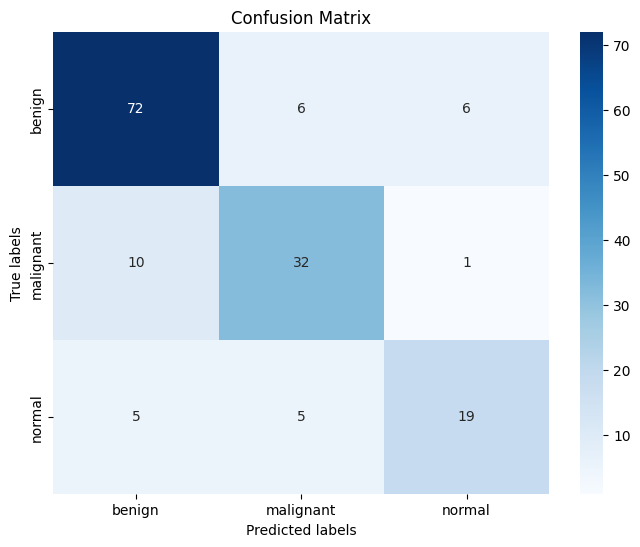

In [9]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

def classification_metrics_multiclass(y_true, y_pred, model, fold):
    '''
    Generate multiclass classification analysis
    '''
    
    # Confusion matrix for multiclass
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_score_per_class = f1_score(y_true, y_pred, average=None)
    
    # Overall metrics
    accuracy = (cm.diagonal().sum()) / cm.sum()
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    
    try:
        auc_value = roc_auc_score(y_true, y_pred, multi_class='ovr')
    except ValueError:
        auc_value = None  # AUC calculation might fail if there's not enough variety in predictions
    
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return {
        "model": model, 
        "fold": fold,
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(), 
        "recall_per_class": recall_per_class.tolist(), 
        "f1_score_per_class": f1_score_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_score_macro": f1_score_macro,
        "auc": auc_value, 
        "kappa": kappa
    }

In [11]:
results = classification_metrics_multiclass(y_true, y_pred_classes, 'vgg16', '1')

In [12]:
results

{'model': 'vgg16',
 'fold': '1',
 'confusion_matrix': array([[72,  6,  6],
        [10, 32,  1],
        [ 5,  5, 19]], dtype=int64),
 'accuracy': 0.7884615384615384,
 'precision_per_class': [0.8275862068965517,
  0.7441860465116279,
  0.7307692307692307],
 'recall_per_class': [0.8571428571428571,
  0.7441860465116279,
  0.6551724137931034],
 'f1_score_per_class': [0.8421052631578947,
  0.7441860465116279,
  0.6909090909090909],
 'precision_macro': 0.7675138280591368,
 'recall_macro': 0.7521671058158628,
 'f1_score_macro': 0.7590668001928712,
 'auc': None,
 'kappa': 0.6431195840554593}